In [3]:
import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import copy
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D
from tqdm import tqdm
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
step_size = 5  #多少天预测一天
feature_num = 24  #多少个features，注意不同indicators时的修改！！！！！！


generator_input = keras.Input(shape=(step_size,feature_num))
x = layers.LSTM(75,return_sequences=True)(generator_input)
#x = layers.Dropout(0.2)(x)
#x = layers.LSTM(25)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(units = 50, return_sequences = True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(units = 50, return_sequences = True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(units = 50)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1)(x)
x = layers.LeakyReLU()(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = layers.Input(shape=(step_size+1,1))
y = layers.Conv1D(filters=100, kernel_size=3, activation='relu')(discriminator_input)
y = layers.Conv1D(filters=100, kernel_size=3, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Conv1D(filters=160, kernel_size=2, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(100, activation='relu')(y)
y = layers.Dense(1,activation='sigmoid')(y)
discriminator = keras.models.Model(discriminator_input, y)
discriminator.summary()

# 为了训练稳定，在优化器中使用学习率衰减和梯度限幅（按值）。
#discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
discriminator_optimizer = keras.optimizers.Adam(0.0001, 0.4)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# 将鉴别器（discrimitor）权重设置为不可训练（仅适用于`gan`模型）
discriminator.trainable = False
gan_input = keras.Input(shape=(step_size, feature_num))
gan_output = discriminator(keras.layers.Concatenate(axis=1)([gan_input[:,:,0],generator(gan_input)]))
gan = keras.models.Model(gan_input, gan_output)
#gan_optimizer = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
gan_optimizer = keras.optimizers.Adam(0.0001, 0.4)
gan.compile(optimizer=gan_optimizer, loss='mean_squared_error')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 24)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 75)             30000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 75)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 50)             25200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 50)             0   

In [9]:
dataset_train = pd.read_csv('/content/drive/MyDrive/Capstone_data/AUD_CAD_Processed.csv')
dataset_train.dropna(axis=0, how='any', inplace=True)
dataset_train.drop(['Unnamed: 0'], axis=1, inplace=True)
train_size = 3370 #70% of data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
values = dataset_train.values #67*6
# ensure all data is float
values = values.astype('float32')
training_set_scaled = sc.fit_transform(values[:3371,:])
testing_set_scaled = sc.transform(values[3371:,:])
X_train = []
y_train = []
for i in range(5, train_size+1):
    X_train.append(training_set_scaled[i-5:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_num))
train_Y = y_train[:,0]

X_test = []
y_test = []
for i in range(5, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-5:i])
    y_test.append(testing_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], feature_num))
test_Y = y_test[:,0]


In [11]:
batch_size = 1
start = 0
#iterations = 61-1
iterations = train_size-step_size+1


for epoch in range(1):
  print(epoch)
  final = []
  # 开始训练迭代
  for step in tqdm(range(iterations)):
    temp_X = copy.deepcopy(X_train[step])
    temp_X = temp_X.reshape(batch_size,step_size,feature_num)
    temp_Y = copy.deepcopy(train_Y[step])
    temp_Y = temp_Y.reshape(batch_size,1)
    predictions = generator.predict(temp_X)
    # 训练鉴别器（discrimitor）
    for i in range(25):
      aaa = X_train[step]
      input_f = np.concatenate([np.transpose(np.array([aaa[:,0]])), predictions], 0)
      input_r = np.concatenate([np.transpose(np.array([aaa[:,0]])), temp_Y], 0)
      input = np.concatenate([[input_f],[input_r]])
      labels = np.concatenate([[np.ones((1, 1))], [np.zeros((1, 1))]])   
      d_loss = discriminator.train_on_batch(input, labels)
    # 训练生成器（generator）（通过gan模型，鉴别器（discrimitor）权值被冻结）
    for i in range(5):
      misleading_targets = np.zeros((batch_size, 1))
      a_loss = gan.train_on_batch(temp_X, [misleading_targets])
    final.append(predictions[0])
  final = np.concatenate((np.array(final), y_train[:,-23:]), axis=1)
  final2 = y_train
  int1 = sc.inverse_transform(final)
  int2 = sc.inverse_transform(final2)
  MAPE_O1 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
  #MAPE_O1 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
  print('training result:',MAPE_O1)

  0%|          | 0/3366 [00:00<?, ?it/s]

0


100%|██████████| 3366/3366 [18:46<00:00,  2.99it/s]


NameError: ignored

In [12]:
#得到测试集结果
final = []
for step in range(len(test_Y)):  #测试集长度
	temp_X = copy.deepcopy(X_test[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])
print(np.array(final).shape)
final = np.concatenate((np.array(final), y_test[:,-23:]), axis=1)
final2 = y_test
int1 = sc.inverse_transform(final)
int2 = sc.inverse_transform(final2)
#MAPE_O2 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('testing result:',MAPE_O2)

(1439, 1)
testing result: 0.030139057


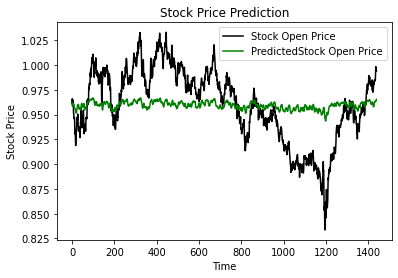

In [13]:
import matplotlib.pyplot as plt
plt.plot(int2[:,0], color = 'black', label = 'Stock Open Price')
plt.plot(int1[:,0], color = 'green', label = 'PredictedStock Open Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
mse_before_scale = mean_squared_error(int2[:,0], int1[:,0])
print('MSE 1 epoches:',mse_before_scale)

MSE 1 epoches: 0.0012028076


In [15]:
!unzip discriminator_30epoch.zip -d /
!unzip generator_30epoch.zip -d /
!unzip gan_30epoch.zip -d /

from keras.models import load_model 

# generator = load_model('generator_1epoch.h5') #打开模型
# discriminator = load_model('discriminator_1epoch.h5') #打开模型

generator = keras.models.load_model("generator_30epoch")
discriminator = keras.models.load_model("discriminator_30epoch")
gan = keras.models.load_model("gan_30epoch")

Archive:  discriminator_30epoch.zip
   creating: /content/discriminator_30epoch/
   creating: /content/discriminator_30epoch/assets/
  inflating: /content/discriminator_30epoch/saved_model.pb  
   creating: /content/discriminator_30epoch/variables/
  inflating: /content/discriminator_30epoch/variables/variables.data-00000-of-00001  
  inflating: /content/discriminator_30epoch/variables/variables.index  
Archive:  generator_30epoch.zip
   creating: /content/generator_30epoch/
   creating: /content/generator_30epoch/assets/
  inflating: /content/generator_30epoch/saved_model.pb  
   creating: /content/generator_30epoch/variables/
  inflating: /content/generator_30epoch/variables/variables.data-00000-of-00001  
  inflating: /content/generator_30epoch/variables/variables.index  
Archive:  gan_30epoch.zip
   creating: /content/gan_30epoch/
   creating: /content/gan_30epoch/assets/
  inflating: /content/gan_30epoch/saved_model.pb  
   creating: /content/gan_30epoch/variables/
  inflating: /c

In [17]:
#得到测试集结果
final = []
for step in range(len(test_Y)):  #测试集长度
	temp_X = copy.deepcopy(X_test[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])
print(np.array(final).shape)
final = np.concatenate((np.array(final), y_test[:,-23:]), axis=1)
final2 = y_test
int1 = sc.inverse_transform(final)
int2 = sc.inverse_transform(final2)
#MAPE_O2 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('testing result:',MAPE_O2)

(1439, 1)
testing result: 0.006044507


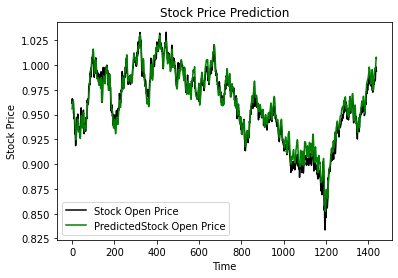

In [18]:
import matplotlib.pyplot as plt
plt.plot(int2[:,0], color = 'black', label = 'Stock Open Price')
plt.plot(int1[:,0], color = 'green', label = 'PredictedStock Open Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
mse_before_scale = mean_squared_error(int2[:,0], int1[:,0])
print('MSE 30 epoches:',mse_before_scale)

MSE 30 epoches: 5.213089e-05
